In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 17 - The GCM model of categorization

## 17.1 The GCM model
The Generalized Context Model (GCM: Nosofsky, 1984, 1986) is an influential and empirically successful model of categorization. It is intended to explain how people make categorization decisions in a task where stimuli are presented, one at a time, over a sequence of trials, and must be classified into one of a small number of categories (usually two) based on corrective feedback.
The GCM assumes that stimuli are stored as exemplars, using their values along underlying stimulus dimensions, which correspond to points in a multidimensional psychological space. The GCM then assumes people make similarity comparisons between the current stimulus and the exemplars, and base their decision on the overall similarities to each category.

$$ c \sim \text{Uniform}(0,5) $$
$$ w \sim \text{Uniform}(0,1) $$  
$$ b = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ij} = \text{exp}[-c\,(w d^1_{ij}+(1-w)d^2_{ij})] $$  
$$ r_i = \frac{b \sum_{j}a_{j}s_{ij}}{b \sum_{j}a_{j}s_{ij}\,+\,(1-b) \sum_{j}(1-a_{j})s_{ij}}$$  
$$ y_i \sim \text{Binomial}(r_i,t)$$  

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/KruschkeData.mat')

nstim = 8
nsubj = 40
t = nstim*nsubj
a = matdata['a'][0]
y = matdata['y'][:,0]

d1 = matdata['d1']
d2 = matdata['d2']
x = matdata['x']

Applied interval-transform to c and added transformed c_interval to model.
Applied interval-transform to w and added transformed w_interval to model.
Assigned NUTS to c_interval
Assigned NUTS to w_interval
 [-----------------100%-----------------] 50000 of 50000 complete in 21.1 sec

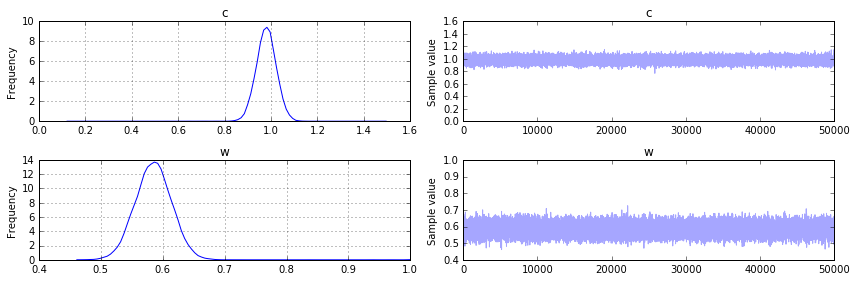

In [3]:
a1 = np.repeat(2-a,nstim).reshape(nstim,nstim).T

with pm.Model() as model1:
    c = pm.Uniform("c",lower=0,upper=5,testval=1.5)
    w = pm.Uniform("w",lower=0,upper=1)
    b = .5
    sij = T.exp(-c*(w*d1+(1-w)*d2))
    
    ri = pm.Deterministic("ri",(b*T.sum(a1*sij,axis=1)) 
                          / (b*T.sum(a1*sij,axis=1)+(1-b)*T.sum((1-a1)*sij,axis=1)))
    yi = pm.Binomial("yi",p=ri,n=t,observed=y)
       
    # start=pm.find_MAP()
    # step=pm.NUTS(scaling=start)
    trace1=pm.sample(5e4)

pm.traceplot(trace1,varnames=['c','w'])
plt.show()

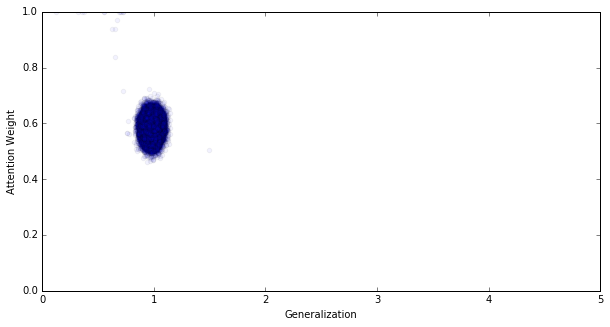

In [4]:
# Fig. 17.3
fig = plt.figure(figsize=(10, 5))
ctr=trace1['c']
wtr=trace1['w']
plt.scatter(ctr,wtr,alpha=.05)
plt.xlabel('Generalization')
plt.ylabel('Attention Weight')
plt.axis((0,5,0,1))
plt.show()

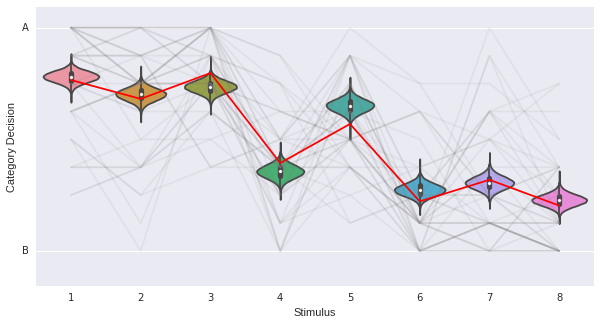

In [5]:
# Fig. 17.4
ppc = pm.sample_ppc(trace1, samples=500, model=model1, size=100)
import seaborn as sns
fig = plt.figure(figsize=(10, 5))
yipred=np.asarray(ppc['yi']).reshape(50000,8)
ax = sns.violinplot(data=yipred)
plt.plot(np.float32(x).T*40,color='gray',alpha=.1)
plt.plot(np.mean(np.float32(x).T*40,axis=1),color='r',alpha=1)
plt.xticks(np.arange(8),''.join(map(str, np.arange(1,9))))
plt.yticks([0,t],('B','A'))
plt.xlabel('Stimulus')
plt.ylabel('Category Decision')
plt.show()

## 17.2 Individual differences in the GCM


$$ c_k \sim \text{Uniform}(0,5) $$
$$ w_k \sim \text{Uniform}(0,1) $$  
$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  
$$ r_{ik} = \frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}$$  
$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

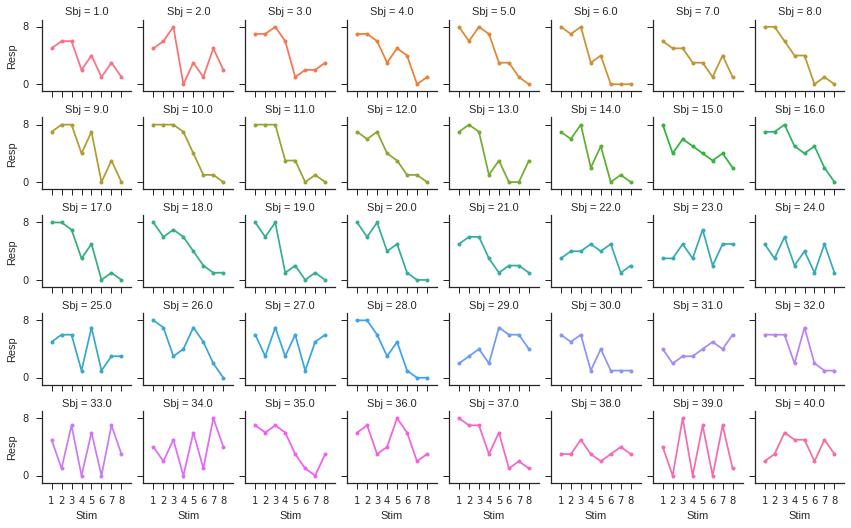

In [6]:
# Fig. 17.5
sns.set(style="ticks")

# Create a dataset with many short random walks
x2 = np.float32(x)
subjvect=[]
stimvect=[]
respvect=[]
for i in range(nstim):
    for j in range(nsubj):
        subjvect.append(j+1)
        stimvect.append(i+1)
        respvect.append(x2[j,i])
df = pd.DataFrame(np.c_[respvect, stimvect, subjvect],
                  columns=["Resp", "Stim", "Sbj"])

grid = sns.FacetGrid(df, col="Sbj", hue="Sbj", col_wrap=8, size=1.5)
grid.map(plt.plot, "Stim", "Resp", marker="o", ms=4)
# Adjust the tick positions and labels
grid.set(xticks=np.arange(1,9), yticks=[0, 8],
         xlim=(0, 9), ylim=(-1, 9))
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

Applied interval-transform to c and added transformed c_interval to model.
Applied interval-transform to w and added transformed w_interval to model.
 [-----------------100%-----------------] 3001 of 3000 complete in 61.3 sec

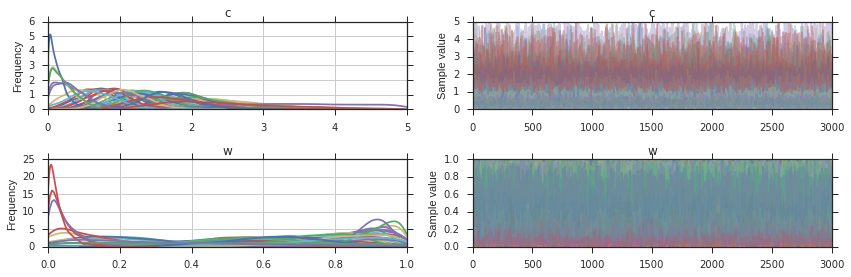

In [7]:
a1 = np.repeat(2-a,nstim).reshape(nstim,nstim).T
y2 = x2

with pm.Model() as model2:
    c = pm.Uniform("c",lower=0,upper=5,shape=nsubj)
    w = pm.Uniform("w",lower=0,upper=1,shape=nsubj)
    b = .5
    yi=[]
    for i in range(nsubj):
        sij = T.exp(-c[i]*(w[i]*d1+(1-w[i])*d2))

        ri = pm.Deterministic("ri",(b*T.sum(a1*sij,axis=1)) 
                              / (b*T.sum(a1*sij,axis=1)+(1-b)*T.sum((1-a1)*sij,axis=1)))
        
        yi.append([pm.Binomial("yi_%i"%i,p=ri,n=nstim,observed=y2[i])])

    start=pm.find_MAP()
    step=pm.NUTS(scaling=start)
    trace2=pm.sample(3e3,step=step)

pm.traceplot(trace2,varnames=['c','w'])
plt.show()

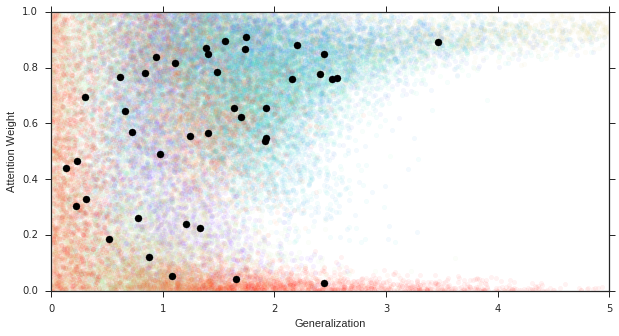

In [8]:
# Fig. 17.7
burnin=2000
fig = plt.figure(figsize=(10, 5))
ctr=np.squeeze(trace2['c'])
wtr=np.squeeze(trace2['w'])
from matplotlib import cm as cm
colors = cm.rainbow(np.linspace(0, 1, nsubj))
for i in range(nsubj):
    plt.scatter(ctr[burnin:,i],wtr[burnin:,i],color=colors[i],alpha=.05)
    
plt.scatter(np.mean(ctr[burnin:,:],axis=0),np.mean(wtr[burnin:,:],axis=0),s=50,color='black',alpha=1)
plt.xlabel('Generalization')
plt.ylabel('Attention Weight')
plt.axis((0,5,0,1))
plt.show()

## 17.3 Latent groups in the GCM


$$ \mu_{1}^w,\delta \sim \text{Uniform}(0,1)$$
$$ \mu_{2}^w = \text{min}(1,\mu_{1}^w+\delta) $$
$$ \sigma^w \sim \text{Uniform}(0.01,1)$$
$$ \mu^c \sim \text{Uniform}(0,5)$$
$$ \sigma^c \sim \text{Uniform}(0.01,3)$$
$$ \phi^c,\phi^g \sim \text{Uniform}(0,1)$$
$$ z_{k}^c \sim \text{Bernoulli}(\phi^c)$$
$$ z_{k}^g \sim \text{Bernoulli}(\phi^g)$$

$$ c_k \sim \text{Gaussian}(\mu^c,\frac{1}{(\sigma^c)^2})_{\mathcal I(0,5)} $$
$$ w_k \sim
\begin{cases}
\text{Gaussian}(\mu_{1}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 0$} \\
\text{Gaussian}(\mu_{2}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 1$}
\end{cases}  $$

$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  

$$ r_{ik} =
\begin{cases}
\frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}  & \text{if $z_{k}^c = 0$} \\
\frac{1}{2}  & \text{if $z_{k}^c = 1$}
\end{cases}  $$


$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

In [9]:
with pm.Model() as model3:
    mu1w = pm.Uniform("mu1w",lower=0,upper=1)
    delta = pm.Uniform("delta",lower=0,upper=1)
    mu2w = pm.Deterministic("mu2w",T.clip(mu1w+delta,0,1))
    
    sigmaw = pm.Uniform("sigmaw",lower=.01,upper=1)
    muc = pm.Uniform("muc",lower=0,upper=5)
    sigmac = pm.Uniform("sigmac",lower=.01,upper=3)
    
    phic = pm.Uniform("phic",lower=0,upper=1)
    phig = pm.Uniform("phig",lower=0,upper=1)
    
    zck = pm.Bernoulli("zck",p=phic,shape=nsubj)
    zcg = pm.Bernoulli("zcg",p=phig,shape=nsubj)
    
    b = .5
    
    c1=T.clip(pm.Normal("c1",mu= muc,sd=sigmac,shape=nsubj),0,5)
    muw = mu1w*(1-zcg) + mu2w*zcg
    w1=T.clip(pm.Normal("w1",mu= muw,sd=sigmaw,shape=nsubj),0,1)
    
    yi=[]
    # c1=[]
    # w1=[]
    for i in range(nsubj):
        # c1.append([T.clip(pm.Normal("c1_%i"%i,mu= muc,sd=sigmac),0,5)])
        # muw = mu1w*(1-zcg[i]) + mu2w*zcg[i]
        # w1.append([T.clip(pm.Normal("w1_%i"%i,mu= muw,sd=sigmaw),0,1)])
        
        # sij = T.exp(-c1[i][0]*(w1[i][0]*d1+(1-w1[i][0])*d2))
        sij = T.exp(-c1[i]*(w1[i]*d1+(1-w1[i])*d2))
        
        ri1 = [(b*T.sum(a1*sij,axis=1)) / (b*T.sum(a1*sij,axis=1)+(1-b)*T.sum((1-a1)*sij,axis=1))]
        ri2 = T.constant(np.ones(nstim)*.5)
        
        yi.append([pm.Binomial("yi_%i"%i,p=ri1*(1-zck[i]) + ri2*zck[i],n=nstim,observed=y2[i])])

    start=pm.find_MAP()
    step=pm.NUTS(scaling=start)
    trace3=pm.sample(5e3)

Applied interval-transform to mu1w and added transformed mu1w_interval to model.
Applied interval-transform to delta and added transformed delta_interval to model.
Applied interval-transform to sigmaw and added transformed sigmaw_interval to model.
Applied interval-transform to muc and added transformed muc_interval to model.
Applied interval-transform to sigmac and added transformed sigmac_interval to model.
Applied interval-transform to phic and added transformed phic_interval to model.
Applied interval-transform to phig and added transformed phig_interval to model.
Assigned NUTS to mu1w_interval
Assigned NUTS to delta_interval
Assigned NUTS to sigmaw_interval
Assigned NUTS to muc_interval
Assigned NUTS to sigmac_interval
Assigned NUTS to phic_interval
Assigned NUTS to phig_interval
Assigned BinaryGibbsMetropolis to zck
Assigned BinaryGibbsMetropolis to zcg
Assigned NUTS to c1
Assigned NUTS to w1
 [-----------------100%-----------------] 5001 of 5000 complete in 778.8 sec

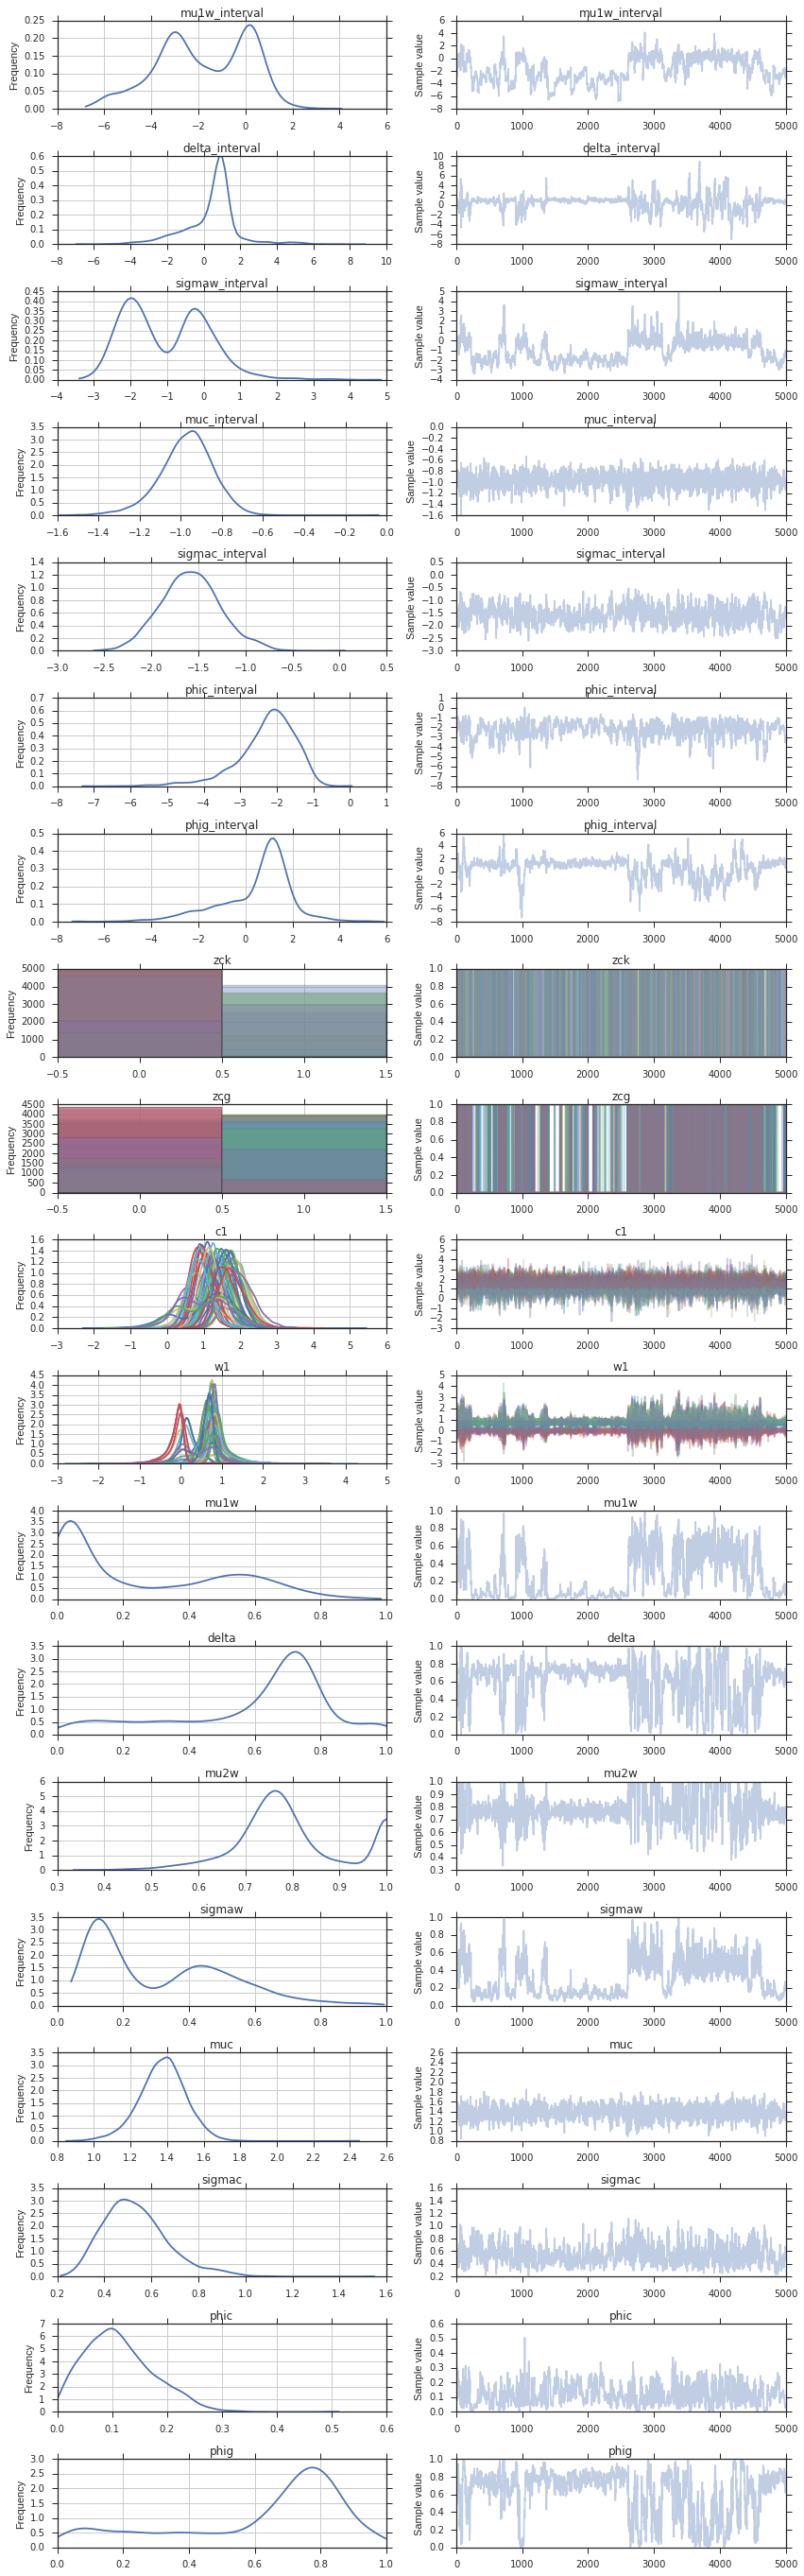

In [10]:
pm.traceplot(trace3)
plt.show()

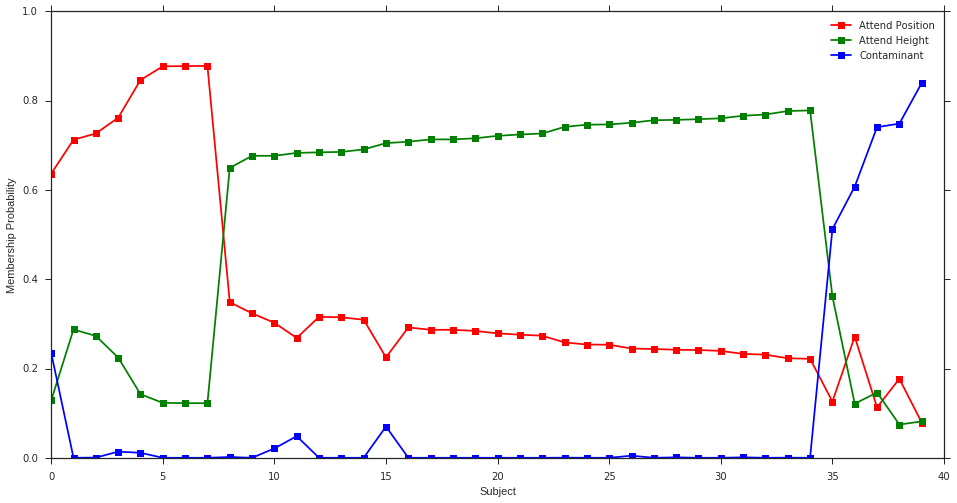

In [11]:
# Fig. 17.9
zc=np.squeeze(trace3['zck'][1000:])
zg=np.squeeze(trace3['zcg'][1000:])
z = (zc == 0) * (zg + 1) + 3 * (zc == 1)
z1=np.zeros((nsubj,3))
for i in range(nsubj):
    sbjid=z[:,i]
    z1[i]=[np.sum(sbjid==1)/len(sbjid),np.sum(sbjid==2)/len(sbjid),np.sum(sbjid==3)/len(sbjid)]
ord1=[]
for i in range(3):
    ordtmp=np.argsort(z1[:,i])
    ordtmp=ordtmp[z1[ordtmp,i]>.5]
    ord1.extend(ordtmp)
# ord1=ord1[::-1]
fig = plt.figure(figsize=(16, 8))

plt.plot(z1[ord1,0],color='r',marker='s')
plt.plot(z1[ord1,1],color='g',marker='s')
plt.plot(z1[ord1,2],color='b',marker='s')
plt.legend(['Attend Position','Attend Height','Contaminant'])
plt.ylim([0,1])
plt.xlabel('Subject')
plt.ylabel('Membership Probability')
plt.show()

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


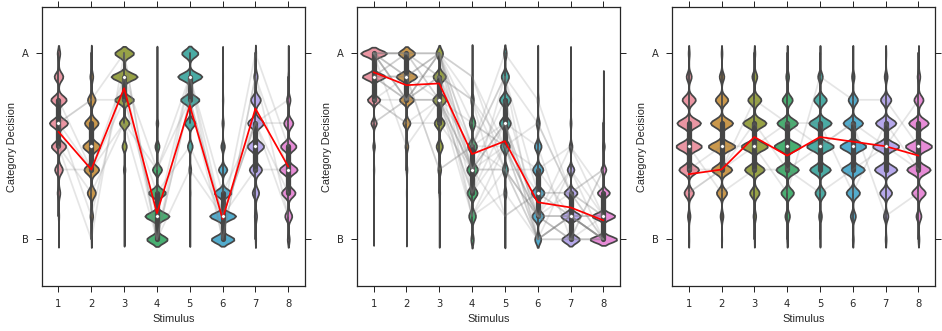

In [12]:
# Fig. 17.10
ppc = pm.sample_ppc(trace3, samples=500, model=model3, size=100)

import seaborn as sns

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1,3)
for ip in range(3):
    ax = plt.subplot(gs[ip])
    idx = np.nonzero(z1[:,ip]>.5)
    
    rndsize=np.round(50000/np.size(idx))
    yipred=np.zeros((rndsize*np.size(idx),8))
    for i,i2 in enumerate(np.squeeze(idx)):
        yipred1=np.asarray(ppc['yi_%i'%i2]).reshape(50000,8)
        yipred[0+i*rndsize:rndsize+i*rndsize,:]=yipred1[np.random.choice(50000,rndsize),:]
    
    ax = sns.violinplot(data=yipred)
    plt.plot(np.squeeze(x2[idx,:]).T,color='gray',alpha=.2)
    plt.plot(np.squeeze(np.mean(x2[idx,:],axis=1)),color='red',alpha=1)
    plt.xticks(np.arange(8),''.join(map(str, np.arange(1,9))))
    plt.yticks([0,nstim],('B','A'))
    plt.xlabel('Stimulus')
    plt.ylabel('Category Decision')
plt.show()